In [7]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [8]:
sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

plt.rcParams['font.size'] = 16 # set some basic plotting parameters

In [22]:
ball_normal = np.genfromtxt("run_1_normal.csv", skip_header=15, delimiter=",")

time_n = ball_normal[:, 0]
volt_n = ball_normal[:, 1]

threshold = 2
print(ball_normal)

[[-0.5         0.79758245]
 [-0.4998      0.79724951]
 [-0.4996      0.79724951]
 ...
 [ 4.4994      0.79758245]
 [ 4.4996      0.79758245]
 [ 4.4998      0.79758245]]


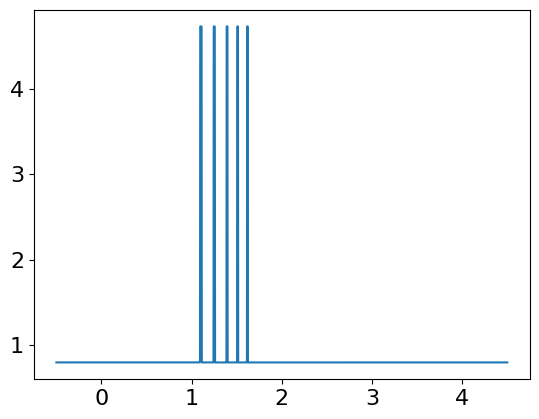

In [23]:
plt.plot(time_n, volt_n)

In [11]:
peak_left = []
peak_right = []

print(np.shape(peak_left))

for i in range(len(time_n)):
    if volt_n[i-1] < threshold and volt_n[i] > threshold:
        peak_left.append(time_n[i])
    if volt_n[i-1] > threshold and volt_n[i] < threshold:
        peak_right.append(time_n[i])

(0,)


In [12]:
print(peak_left)
print(peak_right)

[1.0932, 1.2428, 1.3862, 1.504, 1.6134]
[1.111, 1.257, 1.3976, 1.5144, 1.6226]


In [13]:
times = []
sigmas = []

for t_left, t_right in zip(peak_left, peak_right):
    t = np.mean([t_left, t_right])
    sigma = np.abs(t_left - t)

    times.append(t)
    sigmas.append(sigma)

In [14]:
for i in range(len(times)):
    print(f"time = {times[i]:.3f} +- {sigmas[i]:.3f} s")

time = 1.102 +- 0.009 s
time = 1.250 +- 0.007 s
time = 1.392 +- 0.006 s
time = 1.509 +- 0.005 s
time = 1.618 +- 0.005 s


In [15]:
gate_pos = np.genfromtxt("Gate_pos.csv", skip_header=1, delimiter=",") * 1/100

distances = np.mean(gate_pos, axis=0)
sigma_distances = np.std(gate_pos, axis=0)/np.sqrt(4)

for i in range(len(distances)):
    print(f"Gate {i}: {distances[i]:.5f} +- {sigma_distances[i]:.5f} m")

Gate 0: 0.24757 +- 0.00016 m
Gate 1: 0.37313 +- 0.00032 m
Gate 2: 0.52338 +- 0.00037 m
Gate 3: 0.67110 +- 0.00013 m
Gate 4: 0.82533 +- 0.00009 m


In [16]:
def distance_of_time(t, a, v0, s0):
    return 1/2 * a * t**2 + v0 * t + s0

In [17]:
chi2fit = Chi2Regression(distance_of_time, times, distances, sigma_distances)

minuit_chi2 = Minuit(chi2fit, a=10, v0=0, s0=0.1)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()  

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.029                      │              Nfcn = 79               │
│ EDM = 3.42e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.468   │   0.006   │            │            │         │         │       │
│ 1 │ v0   │  -0.877   │   0.008   │            │            │         │         │       │
│ 2 │ s0   │   0.322   │   0.005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         a        v0        s0 │
├────┼───────────────────────────────┤
│  a │  3.29e-05 -0.045e-3  0.030e-3 │
│ v0 │ -0.045e-3  6.16e-05 -0.041e-3 │
│ s0 │  0.030e-3 -0.041e-3  2.75e-05 │
└────┴───────────────────────────────┘

In [18]:
a_fit, v0_fit, s0_fit = minuit_chi2.values[:]

for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

chi2_value = minuit_chi2.fval
Ndof = len(times) - 3

Prob_value = stats.chi2.sf(chi2_value, Ndof)
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: a = 1.46819 +/- 0.00573
Fit value: v0 = -0.87685 +/- 0.00785
Fit value: s0 = 0.32228 +/- 0.00524
Chi2 value: 4.0   Ndof = 2    Prob(Chi2,Ndof) = 0.133


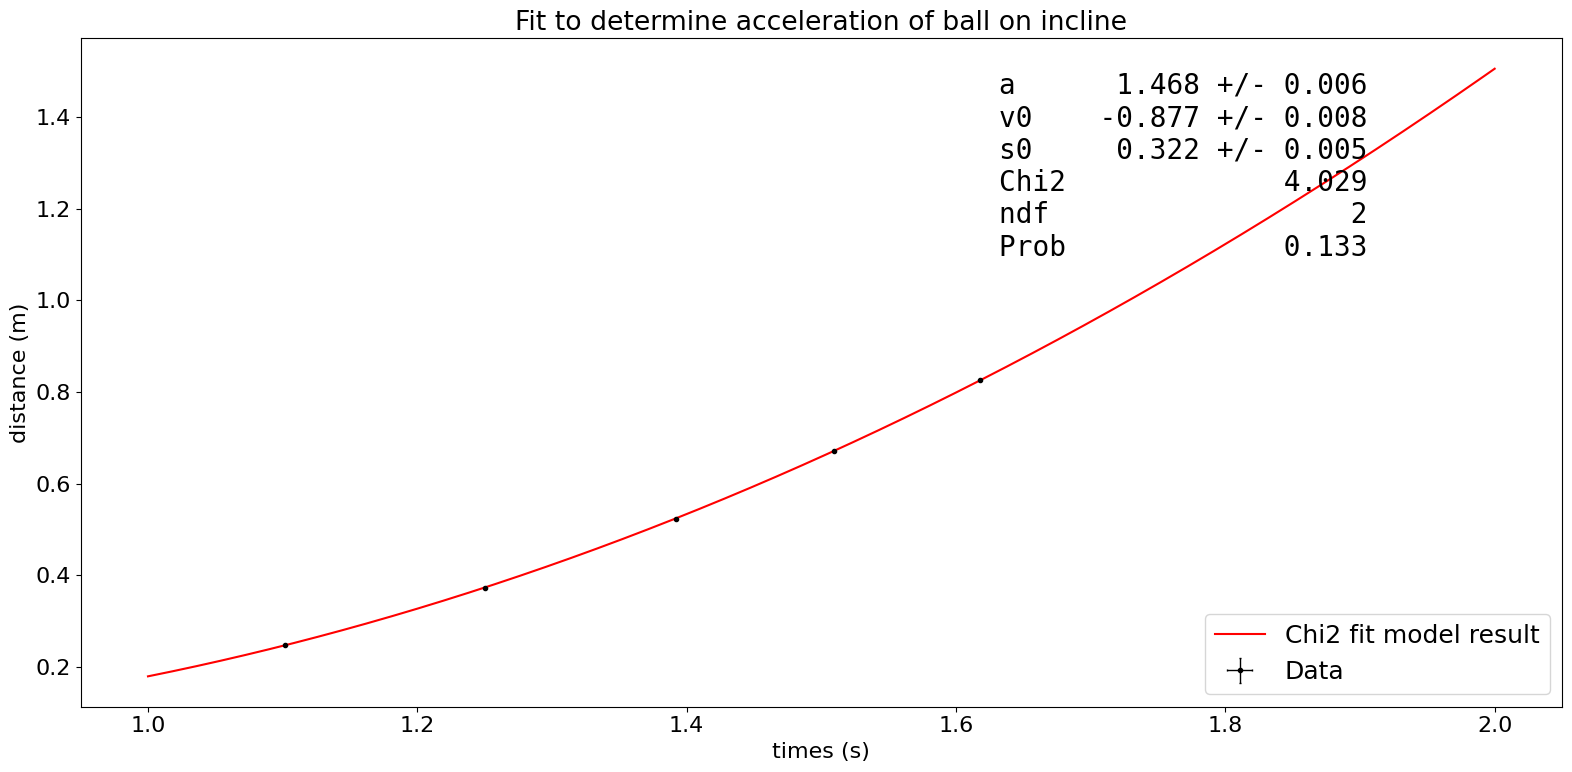

In [19]:
# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(times, distances, yerr=sigma_distances, xerr=0.0, label='Data', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="times (s)", # the label of the y axis
       ylabel="distance (m)",  # the label of the y axis
       title="Fit to determine acceleration of ball on incline") # the title of the plot

# Adding fit function to plot:
x_axis = np.linspace(1, 2, 1000)
ax.plot(x_axis, distance_of_time(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'a':   [minuit_chi2.values['a'], minuit_chi2.errors['a']],
     'v0':       [minuit_chi2.values['v0'], minuit_chi2.errors['v0']],
     's0':       [minuit_chi2.values['s0'], minuit_chi2.errors['s0']],
     'Chi2':     chi2_value,
     'ndf':      Ndof,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower right', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()